In [1]:
from resources.CMUTweetTagger import runtagger_parse
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
tweets = []
for period in ['pre', 'post']:
    tweets.append(pd.read_json('data/tweets_{}Greta.json'.format(period)))
    
tweets[1].head()

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2019-03-02 09:14:52+00:00,1101772852863340544,Extinction @ExtinctionR are right. Only radic...,0,1,NaN,NaN
1,2019-03-02 09:14:52+00:00,1101772852586409988,“We only have 12 years to fix this” is the mos...,0,0,227.0,1038.0
2,2019-03-02 09:14:50+00:00,1101772843694608384,Our voices are loud &amp; clear. We need #Clim...,0,0,438.0,1413.0
3,2019-03-02 09:14:49+00:00,1101772840980832256,@MeganMcCubbin @HouseofCommons @CarolineLucas ...,0,0,25.0,55.0
4,2019-03-02 09:14:42+00:00,1101772811763412992,We're thanking people working on the climate c...,0,0,55.0,332.0


`original_retweet_count` and `original_favorite` means that the tweet is not a retweet.

## Tag tweets

In [4]:
## test 
tweets_pre = tweets[0][:100]

In [5]:
ARK_TWEET_NLP_PATH = 'java -XX:ParallelGCThreads=2 -Xmx500m -jar resources/ark-tweet-nlp-0.3.2/ark-tweet-nlp-0.3.2.jar'

tagged_tweets = runtagger_parse(tweets_pre['text'].values, run_tagger_cmd=ARK_TWEET_NLP_PATH)

In [8]:
tagged_tweets[1]

[('“', ',', 0.9583),
 ('The', 'D', 0.9921),
 ('transition', 'N', 0.9997),
 ('to', 'P', 0.9861),
 ('accessible', 'A', 0.9451),
 ('and', '&', 0.9977),
 ('clean', 'A', 0.8696),
 ('energy', 'N', 0.9954),
 ('is', 'V', 0.9977),
 ('a', 'D', 0.9988),
 ('duty', 'N', 0.9973),
 ('that', 'P', 0.9858),
 ('we', 'O', 0.999),
 ('owe', 'V', 0.9992),
 ('towards', 'P', 0.993),
 ('millions', 'N', 0.9904),
 ('of', 'P', 0.9991),
 ('our', 'D', 0.9987),
 ('brothers', 'N', 0.99),
 ('and', '&', 0.9979),
 ('sisters', 'N', 0.9657),
 ('around', 'P', 0.997),
 ('the', 'D', 0.9995),
 ('world', 'N', 0.9766),
 (',', ',', 0.9979),
 ('poorer', 'A', 0.9831),
 ('countries', 'N', 0.9996),
 ('and', '&', 0.9984),
 ('generations', 'N', 0.958),
 ('yet', 'R', 0.9825),
 ('to', 'P', 0.995),
 ('come', 'V', 0.9984),
 ('”', ',', 0.9752),
 ('-', ',', 0.7817),
 ('@Pontifex', '@', 0.9967),
 ('Francis', '^', 0.9996),
 ('https://t.co/RSzXXlgt7Z', 'U', 0.9883),
 ('#LaudatoSi', '#', 0.9083),
 ('#ParisAgreement', '#', 0.9719),
 ('https://t.c

In [7]:
def create_words_df(df, tagged_tweets):
    # Keep only nouns (N), verbs (V), adverbs (R), adjectives (A), pronoun (O) 
    # For now keep also hashtags
    tweets_words = list()
    for i, tags in enumerate(tagged_tweets):
        tweet_id = df.loc[i, 'id']
        for word, tag, conf in tags:
            if tag in ["#", 'N', 'V', 'R', 'A', 'O']:
                tweets_words.append({
                    'id':tweet_id,
                    'word': word.lower(),
                    'tag': tag,
                    'conf': conf
                })
                
    return pd.DataFrame(tweets_words)

In [32]:
words_pre = create_words_df(tweets_pre, tagged_tweets)
words_pre.head()

,id,word,tag,conf
0,1006327664976617472,new,A,0.9980
1,1006327664976617472,paper,N,0.9881
2,1006327664976617472,shows,V,0.9870
3,1006327664976617472,temperature,N,0.9922
4,1006327664976617472,goals,N,0.9671


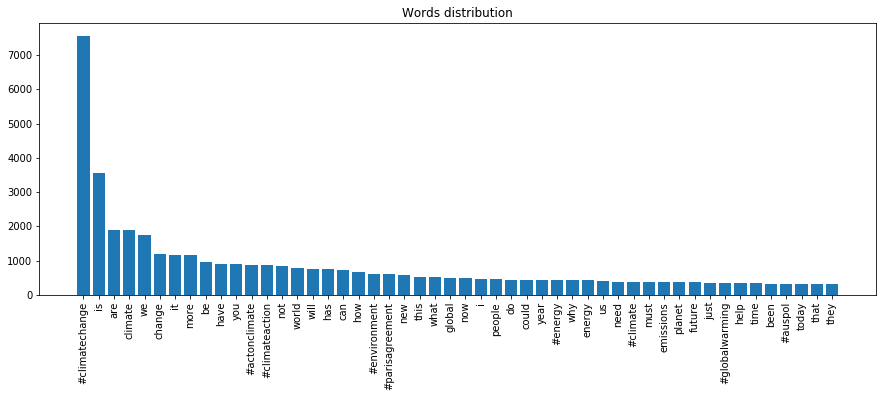

In [33]:
word_counts = words_pre.word.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

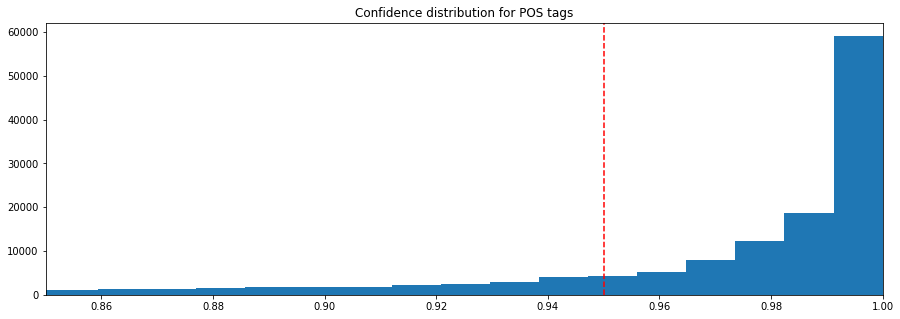

In [34]:
# check confidence
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags')
_ = ax.hist(words_pre.conf, bins=100)
_ = ax.set_xlim(left=0.85, right=1.0)
_ = ax.axvline(x=0.95, c='r', ls='--')
_ = plt.show()

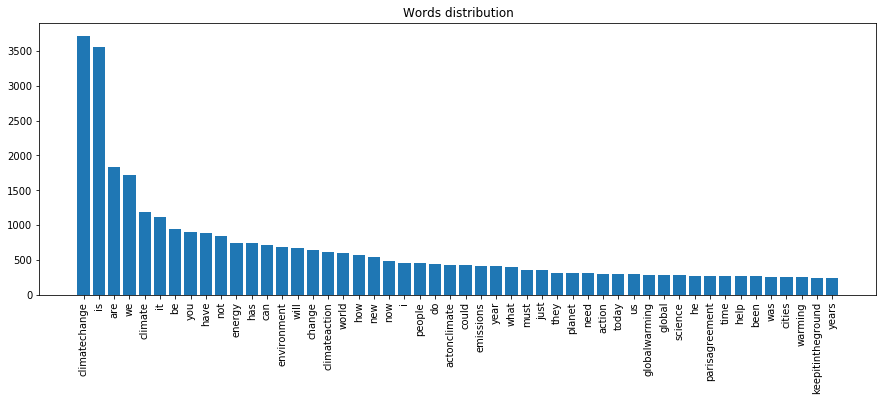

In [38]:
word_counts = words_pre.word.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

In [35]:
words_pre = words_pre[words_pre['conf'] > 0.95]

In [36]:
words_pre.word = words_pre.word.apply(lambda x: re.sub(r'[#]', '', x))